<a href="https://colab.research.google.com/github/ersimbu89/AIMLProjects/blob/master/NLP_Silambarasan_0402.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Import the libraries, load dataset, print shape of data, data description.**

In [48]:
# install and import necessary libraries.

!pip install contractions
import re, string, unicodedata                          # Import Regex, string and unicodedata.
import contractions                                     # Import contractions library.
from bs4 import BeautifulSoup                           # Import BeautifulSoup.

import numpy as np                                      # Import numpy.
import pandas as pd                                     # Import pandas.
import matplotlib.pyplot as plt
import seaborn as sns
import nltk                                             # Import Natural Language Tool-Kit.

nltk.download('stopwords')                              # Download Stopwords.
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords                       # Import stopwords.
from nltk.corpus import wordnet                         # Import wordnet.
from nltk.tokenize import word_tokenize                 # Import Tokenizer.
from nltk.stem.wordnet import WordNetLemmatizer         # Import Lemmatizer.

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

#!pip install vaderSentiment
#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [49]:
# Load dataset

from google.colab import drive
drive.mount('/content/drive')
DataFrame = pd.read_csv("/content/drive/MyDrive/Tweets.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
print("Shape of Data \n")
print("Total Number of rows "+str(DataFrame.shape[0]))
print("Total Number of columns "+str(DataFrame.shape[1]))

Shape of Data 

Total Number of rows 14640
Total Number of columns 15


In [51]:
# Get the column counts, column names, number of non-null values and data-type for each column 

DataFrame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

Inference: Total number of records is not matching across all columns.This indicates the existence of null value or missing value


In [52]:
# Viewing first 5 rows

DataFrame.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


Objective is to detect sentiment from the tweet text.Hence, we will drop all drop all other columns except text and airline_sentiment
  


In [53]:
# Removing columns which have no significance

df= DataFrame[['airline_sentiment','text']]

In [54]:
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it


In [55]:
# check shape of data
df.shape

(14640, 2)

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   airline_sentiment  14640 non-null  object
 1   text               14640 non-null  object
dtypes: object(2)
memory usage: 228.9+ KB


Inference: Total number of row is 14640 in both columns. This indicates no null value exist

In [57]:
#print first 5 rows

print("Dataframe \n")
print(df)

Dataframe 

      airline_sentiment                                                                                                                                                    text
0               neutral                                                                                                                     @VirginAmerica What @dhepburn said.
1              positive                                                                                @VirginAmerica plus you've added commercials to the experience... tacky.
2               neutral                                                                                 @VirginAmerica I didn't today... Must mean I need to take another trip!
3              negative                          @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
4              negative                                                                                     

In [58]:
pd.set_option('display.max_colwidth', None) # Display full dataframe information (Non-turncated Text column.)
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it


**3. Text pre-processing: Data preparation.**

In [59]:

# HTML tag removals

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

df['text'] = df['text'].apply(lambda x: strip_html(x))


In [60]:
# Remove contraction

# before Contraction
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it


In [61]:
# Remove contractions(example: I'm to I am)

def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

df['text'] = df['text'].apply(lambda x: replace_contractions(x))


In [62]:
# after contraction

df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you have added commercials to the experience... tacky.
2,neutral,@VirginAmerica I did not today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it is really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,@VirginAmerica and it is a really big bad thing about it


In [ ]:
# Inference: COntractions were removed

In [63]:
# Check numbers in text

df[df['text'].str.contains('\d+')].head()

,airline_sentiment,text
5,negative,@VirginAmerica seriously would pay $30 a flight for seats that did not have this playing.\nit is really the only bad thing about flying VA
7,neutral,"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP"
10,neutral,@VirginAmerica did you know that suicide is the second leading because of death among teens 10-24
11,positive,@VirginAmerica I <3 pretty graphics. so much better than minimal iconography. :D
12,positive,@VirginAmerica This is such a great deal! Already thinking about my 2nd trip to @Australia & I have not even gone on my 1st trip yet! ;p


In [64]:
# Remove the numbers

def remove_numbers(text):
    text = re.sub(r'\d+', '', text)
    return text

df['text'] = df['text'].apply(lambda x: remove_numbers(x))


In [65]:
# Viewing sample data to confirm if numbers were removed successfully

df.loc[[11]]

,airline_sentiment,text
11,positive,@VirginAmerica I < pretty graphics. so much better than minimal iconography. :D


Inference: Number is removed

In [66]:
# remove url

def remove_url(text):
    text = re.sub(r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?','', text)
    return text
df['text'] = df['text'].apply(lambda x: remove_numbers(x))

In [67]:
# Tokenization

df['text'] = df.apply(lambda row: word_tokenize(row['text']), axis=1) 

In [68]:
# Viewing the data after tokenization

df.head()

,airline_sentiment,text
0,neutral,"[@, VirginAmerica, What, @, dhepburn, said, .]"
1,positive,"[@, VirginAmerica, plus, you, have, added, commercials, to, the, experience, ..., tacky, .]"
2,neutral,"[@, VirginAmerica, I, did, not, today, ..., Must, mean, I, need, to, take, another, trip, !]"
3,negative,"[@, VirginAmerica, it, is, really, aggressive, to, blast, obnoxious, ``, entertainment, '', in, your, guests, ', faces, &, they, have, little, recourse]"
4,negative,"[@, VirginAmerica, and, it, is, a, really, big, bad, thing, about, it]"


In [73]:
# stopwords

stop_words = stopwords.words('english')
customlist = ['not', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn',
        "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
        "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
        "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't",'no','nor']
# Set custom stop-word's list as not, couldn't etc. words matter in Sentiment, so not removing them from original data.
stop_words = list(set(stop_words) - set(customlist))
# Appending words in stoplist
stop_words.append('shall')
stop_words.append('must')
stop_words.append('could')
stop_words.append('might')
stop_words.append('need')
stop_words

['how',
 'you',
 'doing',
 'which',
 'our',
 'only',
 'or',
 'o',
 'during',
 'very',
 'your',
 'but',
 'yourself',
 'be',
 'it',
 'have',
 'down',
 "don't",
 'i',
 'for',
 'further',
 'then',
 "you'll",
 'myself',
 'these',
 'and',
 "aren't",
 "she's",
 'what',
 "should've",
 'most',
 'they',
 'does',
 'as',
 'his',
 'we',
 'its',
 'until',
 'under',
 'ourselves',
 'where',
 'any',
 'up',
 'in',
 'to',
 'ain',
 'on',
 'there',
 'y',
 'from',
 'so',
 'too',
 'yourselves',
 'the',
 'd',
 'into',
 'an',
 'below',
 'are',
 'over',
 'has',
 'will',
 'with',
 'such',
 'again',
 'couldn',
 "you'd",
 'himself',
 'through',
 'few',
 'me',
 'against',
 'them',
 'should',
 'both',
 'he',
 'herself',
 'a',
 'off',
 'each',
 'being',
 'hers',
 't',
 'same',
 'who',
 'him',
 'did',
 'out',
 'between',
 'when',
 "it's",
 'other',
 'am',
 'while',
 'than',
 'don',
 'my',
 'had',
 'those',
 'after',
 'at',
 'aren',
 'were',
 'ours',
 'about',
 'why',
 'more',
 'themselves',
 'll',
 'this',
 'if',
 'm'

In [74]:
%%time
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_special_characters(words):
    """Remove special chracters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub('[^a-zA-Z0-9\n\.]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stop_words:
            new_words.append(word)
    return new_words

def lemmatize_list(words):
    lemmatizer = WordNetLemmatizer()
    new_words = []
    for word in words:
        new_words.append(lemmatizer.lemmatize(word, pos = 'v'))
    return new_words

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_special_characters(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = lemmatize_list(words)
    return ' '.join(words)

df['text'] = df.apply(lambda row: normalize(row['text']), axis=1)


CPU times: user 2.51 s, sys: 6.67 ms, total: 2.52 s
Wall time: 2.53 s


In [75]:
df.head()

,airline_sentiment,text
0,neutral,virginamerica dhepburn say
1,positive,virginamerica plus add commercials experience tacky
2,neutral,virginamerica not today mean take another trip
3,negative,virginamerica really aggressive blast obnoxious entertainment guests face little recourse
4,negative,virginamerica really big bad thing


**Vectorization  & Classification models**

In [76]:
# Vectorization (Convert text data to numbers)

vectorizer = CountVectorizer()             
data_features = vectorizer.fit_transform(df['text'])

data_features_df = pd.DataFrame(data = data_features.toarray() , 
                                columns = vectorizer.get_feature_names())     

data_features_df.head()

,aa,aaaand,aaadvantage,aaalwayslate,aaba,aacom,aacustomerservice,aadavantage,aadelay,aadfw,aadv,aadvantage,aafail,aal,aano,aaron,aarp,aaso,aateam,aaus,ab,aback,abandon,abandonment,abassinet,abbreve,abc,abcdef,abcletjetbluestreamfeed,abcnetwork,abcnews,abcnewsbayarea,abcwtvd,abduct,abi,abidfw,abigailedge,abilities,ability,able,...,yrold,yroldtwins,yrs,ystday,ystrdy,yuck,yucki,yulord,yuma,yummy,yup,yvonne,yvonneokaka,yvr,yxe,yxu,yyc,yyj,yyz,yyzua,zabsonre,zackscom,zakkohane,zambia,zccu,zero,zfv,zigzag,zip,zipper,zj,zkatcher,zombie,zone,zoom,zrh,zrhairport,zukes,zurich,zurichnew
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [77]:
freq = pd.DataFrame({'Feature_Name': vectorizer.get_feature_names(),
                     'Count': np.asarray(data_features.sum(axis = 0))[0]}).sort_values('Count', ascending = False)

freq

,Feature_Name,Count
3554,flight,4835
11188,unite,4160
6619,not,3901
11313,usairways,3051
371,americanair,2961
...,...,...
5197,kansas,1
5196,kanne,1
5195,kangaroos,1
5194,kaneshow,1


In [80]:
data_features_df.shape

(14640, 12047)

In [82]:
Labels = df[['airline_sentiment']]
Labels['airline_sentiment'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

In [83]:
Labels['airline_sentiment']=Labels['airline_sentiment'].replace(["negative","neutral","positive"],["0","1","2"])
Labels['airline_sentiment'].unique()

array(['1', '2', '0'], dtype=object)

In [84]:
# converting the data type from object to int

Labels = Labels.astype('int')
Labels['airline_sentiment'].dtype

dtype('int64')

In [86]:
Labels['airline_sentiment'].unique()

array([1, 2, 0])

In [87]:
# Split data into training and testing set.
X_train, X_test, y_train, y_test = train_test_split(data_features_df, Labels, test_size=0.3, random_state=1)

In [88]:
# Building Random forest model for classification of airline sentiments.
# Also calculating the cross validation score.

forest = RandomForestClassifier(n_estimators=100,verbose=2, n_jobs=8,random_state=42)
forest = forest.fit(X_train, y_train)
print(np.mean(cross_val_score(forest, data_features_df, Labels, cv=10)))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100building tree 10 of 100

building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   18.5s


building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74

[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   58.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   40.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  2.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   37.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  2.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]:

0.7404371584699453


In [89]:
# Predict the result for test data using the model built above.
result = forest.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.7s finished


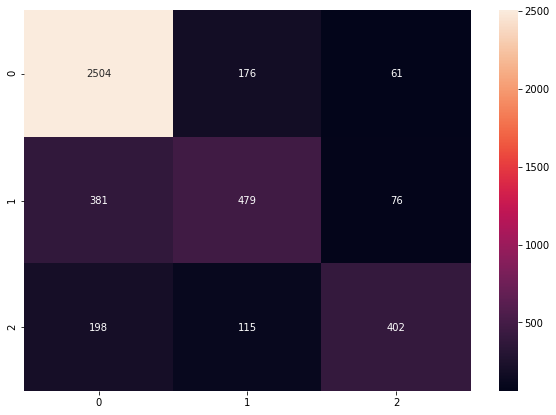

In [90]:
# Print and plot Confusion matirx to get an idea of how the distribution of the prediction is, among all the classes.
conf_mat = confusion_matrix(y_test, result)
df_cm = pd.DataFrame(conf_mat, index = [i for i in "012"],
                  columns = [i for i in "012"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g');

In [93]:
# Using TfidfVectorizer to convert text data to numbers.
vectorizer = TfidfVectorizer()
data_features = vectorizer.fit_transform(df['text'])

data_features_df = pd.DataFrame(data = data_features.toarray() , 
                                columns = vectorizer.get_feature_names())     

data_features_df.head()

,aa,aaaand,aaadvantage,aaalwayslate,aaba,aacom,aacustomerservice,aadavantage,aadelay,aadfw,aadv,aadvantage,aafail,aal,aano,aaron,aarp,aaso,aateam,aaus,ab,aback,abandon,abandonment,abassinet,abbreve,abc,abcdef,abcletjetbluestreamfeed,abcnetwork,abcnews,abcnewsbayarea,abcwtvd,abduct,abi,abidfw,abigailedge,abilities,ability,able,...,yrold,yroldtwins,yrs,ystday,ystrdy,yuck,yucki,yulord,yuma,yummy,yup,yvonne,yvonneokaka,yvr,yxe,yxu,yyc,yyj,yyz,yyzua,zabsonre,zackscom,zakkohane,zambia,zccu,zero,zfv,zigzag,zip,zipper,zj,zkatcher,zombie,zone,zoom,zrh,zrhairport,zukes,zurich,zurichnew
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [94]:
# Split data into training and testing set.
X_train, X_test, y_train, y_test = train_test_split(data_features_df, Labels, test_size=0.3, random_state=42)

In [95]:
# Using Random Forest to build model for the classification of reviews.
# Also calculating the cross validation score.
forest2 = RandomForestClassifier(n_estimators=100,verbose=2, n_jobs=8,random_state=42)
forest2 = forest2.fit(X_train, y_train)
print(np.mean(cross_val_score(forest2, data_features_df, Labels, cv=10)))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100building tree 18 of 100

building tree 19 of 100
building tree 20 of 100
building tree 21 of 100building tree 22 of 100

building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   19.2s


building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100building tree 52 of 100

building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74

[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.0min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  3.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  3.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]:

0.737568306010929


In [96]:
result2 = forest2.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.7s finished


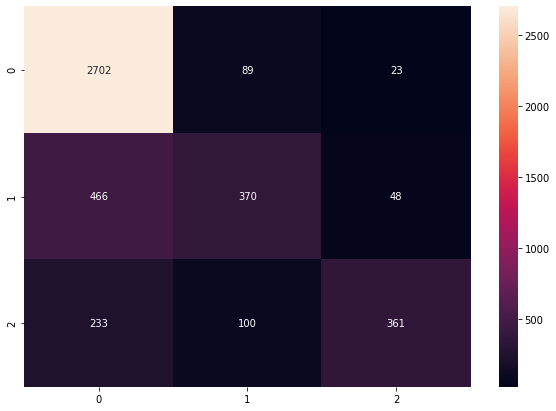

In [97]:
#confusion matrix
conf_mat2 = confusion_matrix(y_test, result2)
df_cm2 = pd.DataFrame(conf_mat2, index = [i for i in "012"],
                  columns = [i for i in "012"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm2, annot=True, fmt='g');

**Summary -**

The objective of this project is to perform sentimental analysis by classifying the customer tweets as Negative(0), Neutral(1) and Positive (2).

  1. I have used Random forest classifier to build the model for this multi-classification problem.

  2.  **Data Cleansing/Data Preprocessing** were performed before building the models

      a. **Noise removal tasks were performed** - (Removal of Special character, numbers, html tags, URL,Non-Ascii words and punctuation)

      b. **Tokenization** - Task of taking a text or set of text and breaking it up into individual tokens. Tokens are usually individual words. I have used NLTK library to tokenize the words

      c. All texts were converted to **lowercase**

      d. **Stopwords** - common words that carry less important meaning than keywords. When using some bag of words based methods, i.e., countVectorizer or tfidf that works on counts and frequency of the words, removing stopwords is great as it lowers the dimensional space.  I have customized the stopwords: appended few words and removed not, couldn't etc from stopwords list. These words matter in Sentiment, so not removing them from original data. Used NTLK library to remove stopwords

      e. **Lemmatization** -  Lemmatization was performed to reduce the different forms of word to core word.

      f. **Joined the words** in the list to convert back to text string in the dataframe So that each row contains the data in text format. 

  3. **Vectorization & Classification Model** -

        a.   **Count Vectorizer** - Transformed given text into a vector on the basis of the frequency (count) of each word that occurs in the entire text . Built the Random Forest model and model accuracy is 74%

        b.   **Tfidf Vectorizer** - TF-IDF is an abbreviation for Term Frequency Inverse Document Frequency. Transformed the text into a meaningful representation of numbers which is used to fit machine algorithm for prediction. Built the Random Forest model and model accuracy is 73.7%

        c. Negative category sentiments were predicted slightly better by TfidfVectorization than count vectorizer

        d. Postive and Neutral sentiments were predicted slightly better by count vectorization than TFID

        e. By considering the accuracy,  CountVectorization performs better than Tfid vectorization



 
